In [4]:
# %pip install pyaudio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
from synchronisation import *
import pyaudio
import time



In [5]:
def generate_sound(samples, volume, fs): # volume range [0.0, 1.0]

    p = pyaudio.PyAudio()
    time.sleep(1)

    output_bytes = (volume * samples).tobytes()

    # for paFloat32 sample values must be in range [-1.0, 1.0]
    stream = p.open(format=pyaudio.paFloat32,
                    channels=1,
                    rate=fs,
                    output=True)

    # play. May repeat with different volume values (if done interactively)
    start_time = time.time()
    stream.write(output_bytes)
    print("Played sound for {:.2f} seconds".format(time.time() - start_time))

    stream.stop_stream()
    stream.close()

    p.terminate()

In [6]:
fs = 44100
chirp_time = 5
t = np.linspace(0, chirp_time, fs*chirp_time)
f_0 = 1000
f_1 = 16000
chirp = signal.chirp(t, f0=f_0, f1=f_1, t1=chirp_time, method='linear')
chirp = chirp / np.max(np.abs(chirp)) * 0.1

symbol = []
for i in range(511):
    if i % 4 == 0:
        symbol.append(1+1j)
    elif i % 4 == 1:
        symbol.append(-1+1j)
    elif i % 4 == 2:
        symbol.append(1-1j)
    elif i % 4 == 3:
        symbol.append(-1-1j)


symbol = np.array(symbol)
conj_symbol = np.conj(symbol)[::-1]
symbol = np.concatenate((symbol, conj_symbol))
symbol = np.insert(symbol, 0, 0)
symbol = np.insert(symbol, 512, 0)
print(symbol.shape)
time_symbol = np.fft.ifft(symbol)
print(time_symbol.shape)
time_symbol = np.real(time_symbol)
time_symbol = time_symbol / np.max(np.abs(time_symbol))
cyclic = np.concatenate((time_symbol[-32:], time_symbol))

symbol_data = []
for i in range(511):
    if i % 4 == 3:
        symbol_data.append(1+1j)
    elif i % 4 == 2:
        symbol_data.append(-1+1j)
    elif i % 4 == 1:
        symbol_data.append(1-1j)
    elif i % 4 == 0:
        symbol_data.append(-1-1j)

symbol_data = np.array(symbol_data)
conj_symbol_data = np.conj(symbol_data)[::-1]
symbol_data = np.concatenate((symbol_data, conj_symbol_data))
symbol_data = np.insert(symbol_data, 0, 0)
symbol_data = np.insert(symbol_data, 512, 0)
print(symbol_data.shape)
time_symbol_data = np.fft.ifft(symbol_data)
print(time_symbol_data.shape)
time_symbol_data = np.real(time_symbol_data)
time_symbol_data = time_symbol_data / np.max(np.abs(time_symbol_data))
cyclic_data = np.concatenate((time_symbol_data[-32:], time_symbol_data))
print(cyclic_data.shape)

(1024,)
(1024,)
(1024,)
(1024,)
(1056,)


In [7]:
to_transmit = np.concatenate((chirp, cyclic, cyclic, cyclic_data, cyclic, cyclic_data))
to_transmit = to_transmit.astype(np.float32)
print(to_transmit.shape)
print(np.max(np.abs(to_transmit)))


(225780,)
1.0


In [13]:
generate_sound(to_transmit, 1, fs)

Played sound for 5.15 seconds


In [9]:
#Signal Import
data = pd.read_csv('data.txt').to_numpy()
data = np.reshape(data, len(data)) 
y = data

54441


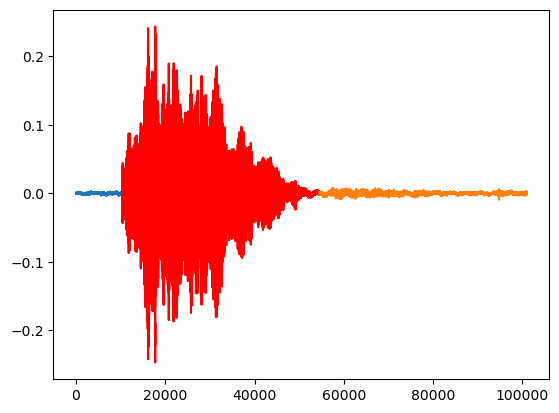

In [13]:
#Synchronization
chirp_time = 1
fs = 44100
t = np.linspace(0, chirp_time, fs*chirp_time)
f_0 = 1000
f_1 = 16000
chirp = signal.chirp(t, f0=f_0, f1=f_1, t1=1, method='linear')
max_index, cross_correlation, lags = matched_filter_synchronisation(y,chirp, 10, fs)
print(max_index)

#Plot
x = np.linspace(0, len(y), len(y))
plt.plot(x[:lags[max_index]],y[:lags[max_index]])
plt.plot(x[lags[max_index]:lags[max_index] + len(chirp)],y[lags[max_index]:lags[max_index] + len(chirp)], color = 'red')
plt.plot(x[lags[max_index] + len(chirp):], y[lags[max_index] + len(chirp):])
plt.show()


c:\Users\Yuxuan Xie\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


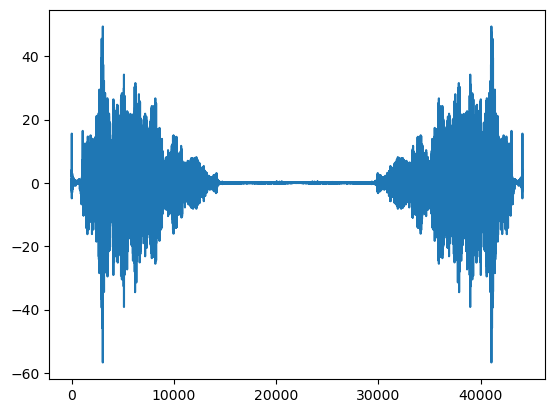

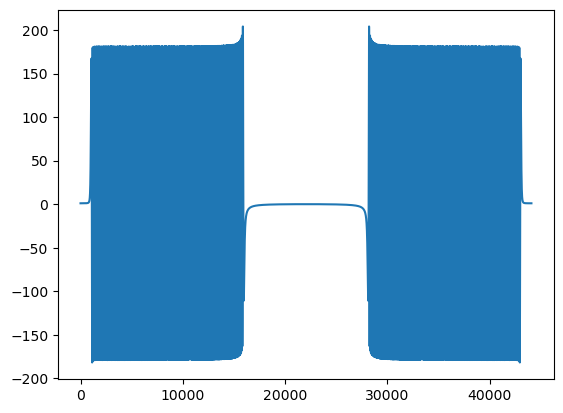

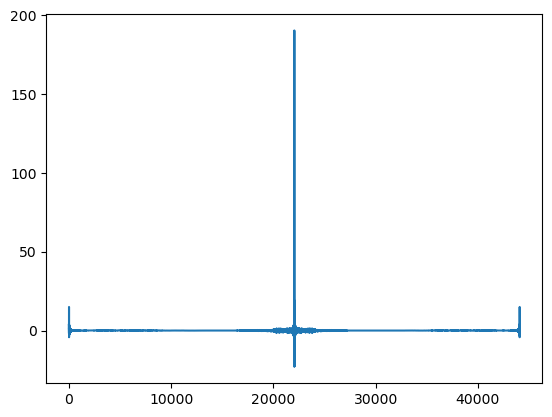

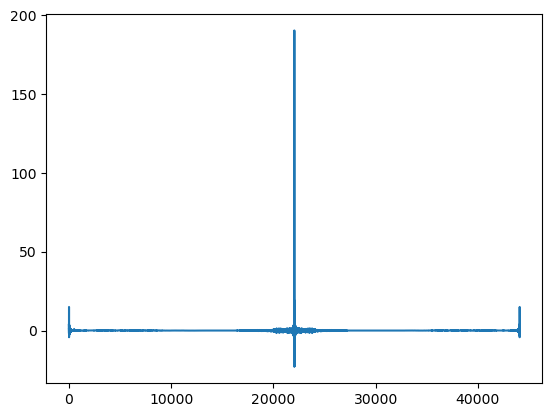

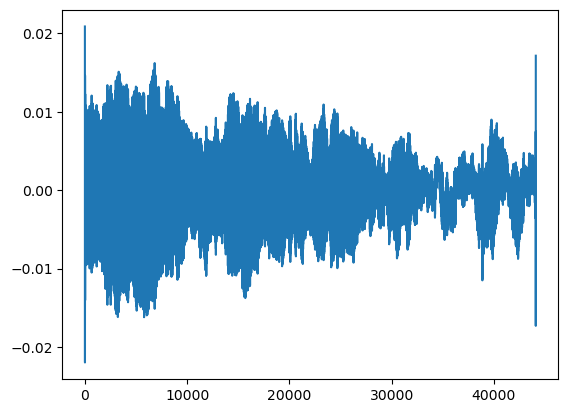

In [18]:
# Channel estimation using the chirp
chirp_data = y[lags[max_index]:lags[max_index] + len(chirp)]
channel_chirp = standered_estimation(chirp, chirp_data, fs)

plt.plot(np.fft.fft(chirp_data, n = 44100))
plt.show()

plt.plot(np.fft.fft(chirp, n = 44100))
plt.show()

channel_freq = np.fft.fft(chirp_data, n = 44100)/np.fft.fft(chirp, n = 44100)
channel_time = np.fft.ifft(channel_freq, n = 44100)

plt.plot(channel_freq)
plt.show()
plt.plot(channel_time)
plt.show()


plt.plot(channel_chirp)
plt.show()

time_channel_chirp = np.fft.ifft(channel_chirp)
time_channel_chirp = np.real(time_channel_chirp)
plt.plot(time_channel_chirp)
plt.show()



plt.show()

c:\Users\kmc07\OneDrive\Desktop\GF3_2\GF3\channel_estimation_chirp.py:25: RuntimeWarning: divide by zero encountered in divide
  channel_estimation = Y / X
c:\Users\kmc07\OneDrive\Desktop\GF3_2\GF3\channel_estimation_chirp.py:25: RuntimeWarning: invalid value encountered in divide
  channel_estimation = Y / X


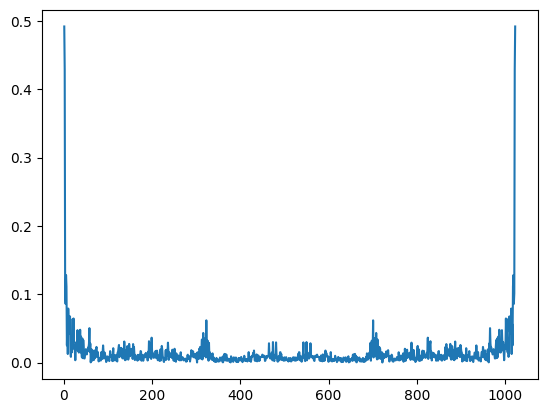

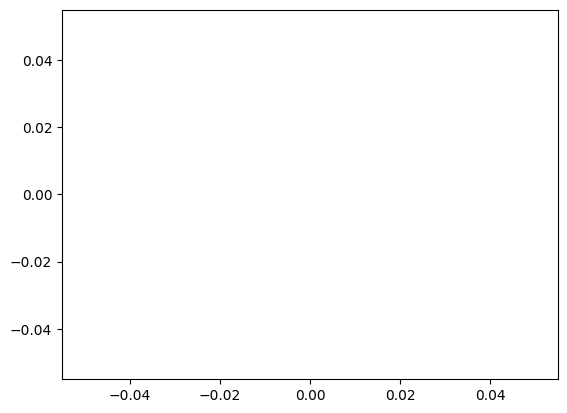

In [10]:
# Channel estimation Using OFDM
n = 1056
#OFDM_DATA = pd.read_csv('OFDM_DATA.csv').to_numpy()
OFDM_DATA = time_symbol_data
Start_index = lags[max_index] + len(chirp)

# Channel estimation
Symbol_One = y[Start_index:Start_index + n]
Symbol_One = Symbol_One[32:]
chanel_estimation = standered_estimation(OFDM_DATA, Symbol_One, 1024)
plt.plot(np.abs(chanel_estimation))
plt.show()
time_channel = np.fft.ifft(chanel_estimation)
plt.plot(np.abs(time_channel))
plt.show()


(1024,)


C:\Users\kmc07\AppData\Local\Temp\ipykernel_37560\2283048407.py:5: RuntimeWarning: invalid value encountered in divide
  Symbol_Two = Symbol_Two / chanel_estimation


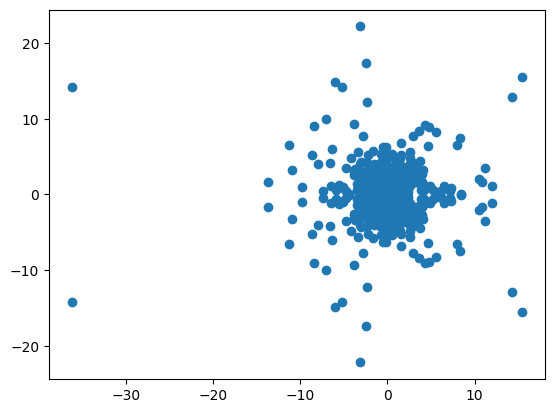

In [11]:
Symbol_Two = y[Start_index + n:Start_index + 2*n]
Symbol_Two = Symbol_Two[32:]
print(Symbol_Two.shape)
Symbol_Two = np.fft.fft(Symbol_Two)
Symbol_Two = Symbol_Two / chanel_estimation
plt.scatter(np.real(Symbol_Two), np.imag(Symbol_Two))
